To facilitate image reading, processing, and visualization, the required Python libraries are imported:

 - **cv2** from the OpenCV library provides efficient methods for reading and manipulating images.

 - **matplotlib.pyplot** is used for generating clear and structured visual outputs.

 - **os** is utilized for constructing file paths in a platform-independent manner, which ensures compatibility across different operating systems.

In [2]:
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import torchvision.transforms as T
import random
import torch

This section defines the list of image filenames to be processed and specifies the base directories for both original images and their corresponding ground truth masks. It is assumed that the dataset is organized hierarchically under a DataSet/train/ directory, with subdirectories:

 - Original/ containing the input images.

 - Ground truth/ containing segmentation masks or annotations.

This explicit path management allows the code to be modular and adaptable to batch processing of multiple samples.

In [4]:
# List of image names to process
image_names = ['1_A.png', "6_A.png", '10_A.png', '23_A.png', '41_A.png', '77_A.png', '110_A.png']

# Base folder paths
original_base = os.path.join('DataSet', 'train', 'Original')
mask_base = os.path.join('DataSet', 'train', 'Ground truth')

processed_original_base = os.path.join('DataSet', 'processed_train', 'Original')
processed_mask_base = os.path.join('DataSet', 'processed_train', 'Ground truth')

original_test_base = os.path.join('DataSet', 'test', 'Original')
mask_test_base = os.path.join('DataSet', 'test', 'Ground truth')

processed_original_test_base = os.path.join('DataSet', 'processed_test', 'Original')
processed_mask_test_base = os.path.join('DataSet', 'processed_test', 'Ground truth')

This code segment processes a predefined list of image filenames by iterating through each corresponding pair of original and ground truth mask images. The goal is to prepare each image for subsequent visualization by storing the processed outputs in memory. Specifically:

- The full file paths for both the original image and its associated mask are dynamically constructed using consistent base directory paths. This ensures that the dataset’s hierarchical structure is respected and that file access remains portable and manageable.

- Each image and its corresponding mask are loaded into memory using OpenCV’s `imread` function. A conditional check verifies that both files were successfully read; otherwise, the current iteration is skipped to maintain fault tolerance.

- Since OpenCV reads images in BGR format by default, the original image is converted to RGB to ensure accurate color rendering, particularly when using libraries like Matplotlib that assume RGB input.

- The mask image is assessed for dimensionality: if it is a single-channel grayscale image, it is converted to a 3-channel RGB format to standardize the input structure. This uniformity is essential for consistent overlay operations and visualization.

- An overlay image is then computed by blending the RGB original and the RGB mask using a weighted sum. This produces a semi-transparent composite image that highlights the annotated regions without obscuring the underlying visual content.

- Finally, the processed original image, mask, and overlay are appended to separate lists. These in-memory structures decouple the data processing and visualization stages, enabling modular notebook design and allowing the processed results to be displayed or analyzed later in a separate code block.


In [ ]:
# Processing loop: read and process images, store results
processed_originals = []
processed_masks = []
processed_overlays = []

for image_name in image_names:
    print(f"Processing: {image_name}")

    original_path = os.path.join(original_base, image_name)
    mask_path = os.path.join(mask_base, image_name)

    original = cv2.imread(original_path)
    mask = cv2.imread(mask_path)

    if original is None or mask is None:
        print(f"Skipping {image_name}: file not found.")
        continue

    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    if len(mask.shape) == 2 or mask.shape[2] == 1:
        mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    else:
        mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    
    overlay = cv2.addWeighted(original_rgb, 0.7, mask_rgb, 0.3, 0)

    processed_originals.append(original_rgb)
    processed_masks.append(mask_rgb)
    processed_overlays.append(overlay)


Processing: 1_A.png
Processing: 6_A.png
Processing: 10_A.png
Processing: 23_A.png
Processing: 41_A.png
Processing: 77_A.png
Processing: 110_A.png


This visualization phase systematically renders each image-mask pair alongside its composite overlay to support qualitative evaluation. The approach emphasizes clarity, consistency, and ease of interpretation through the following strategies:

- **Sequential Visualization:** Iterates through stored lists of processed originals, masks, and overlays to generate a consistent and repeatable display for each image set.

- **Structured Subplot Layout:** Each figure comprises three horizontally aligned subplots—original image, binary mask, and overlay—to facilitate immediate visual comparison across different representations.

- **Focus on Image Content:** Axes are removed from all subplots to eliminate visual clutter and maintain focus on the image data itself.

- **Consistent Styling:** Each subplot is individually titled to clearly indicate its respective content, aiding in interpretability during result analysis.

- **Layout Optimization:** `tight_layout()` is employed to automatically adjust subplot parameters, ensuring appropriate spacing and preventing label or image overlap, thereby enhancing overall readability and aesthetic quality of the figure.


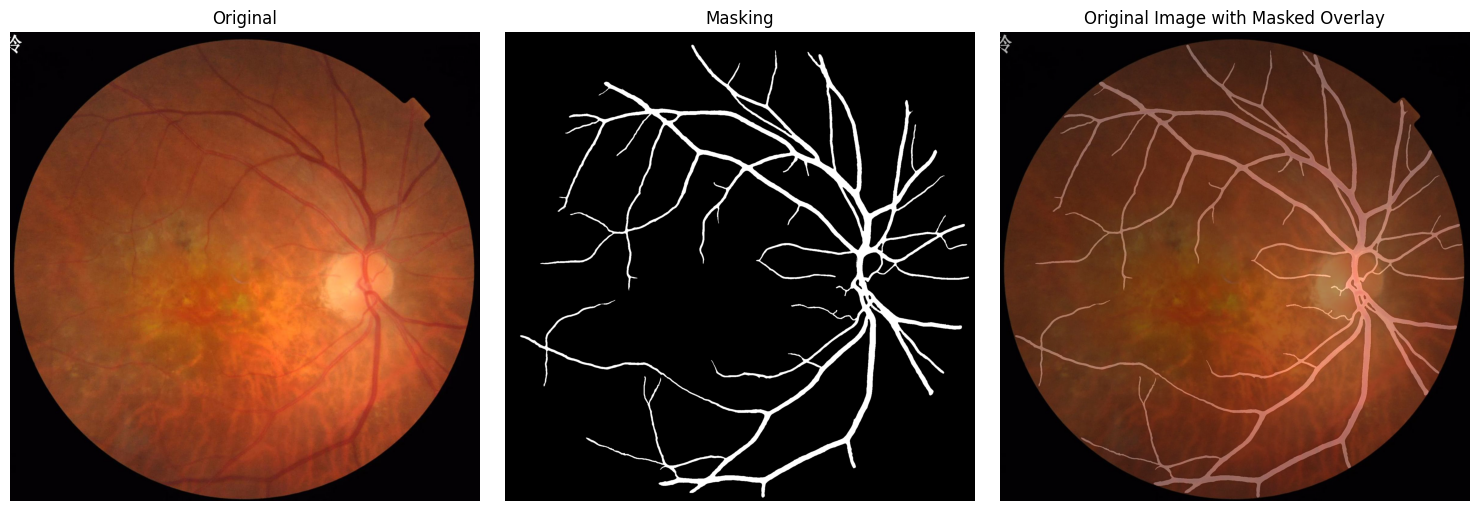

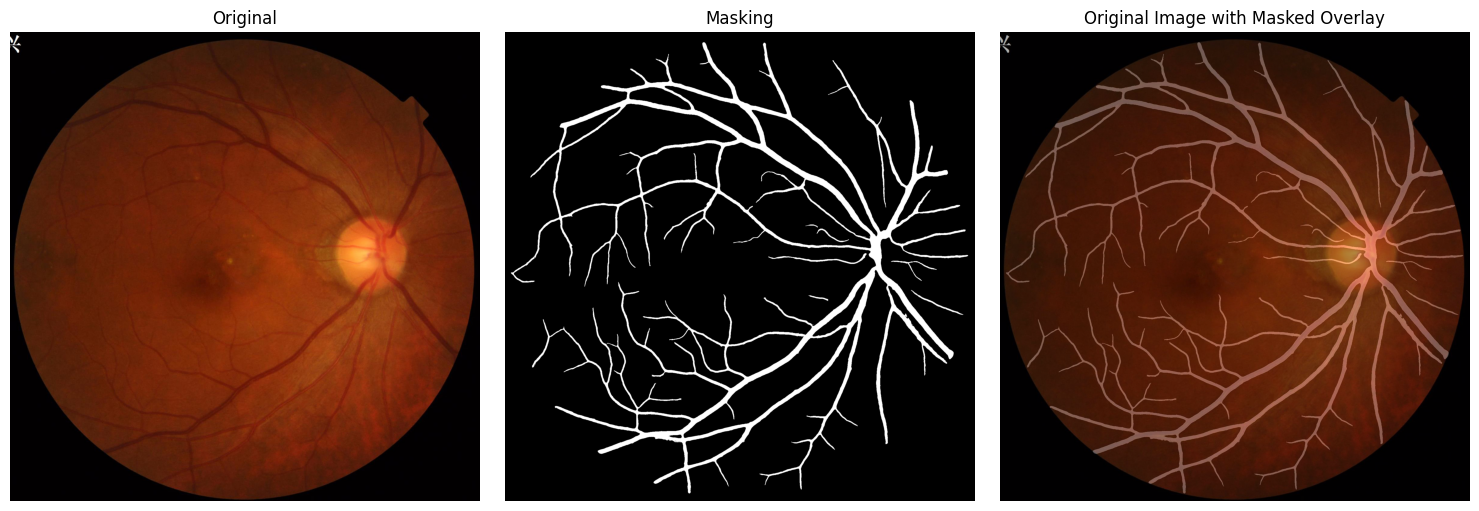

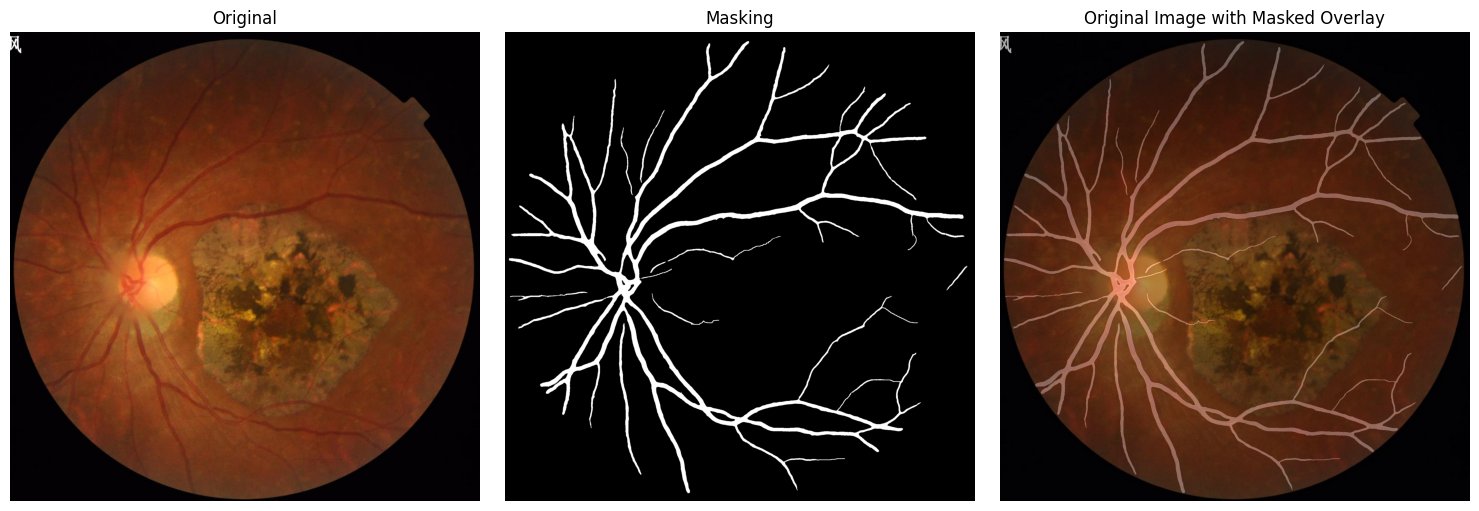

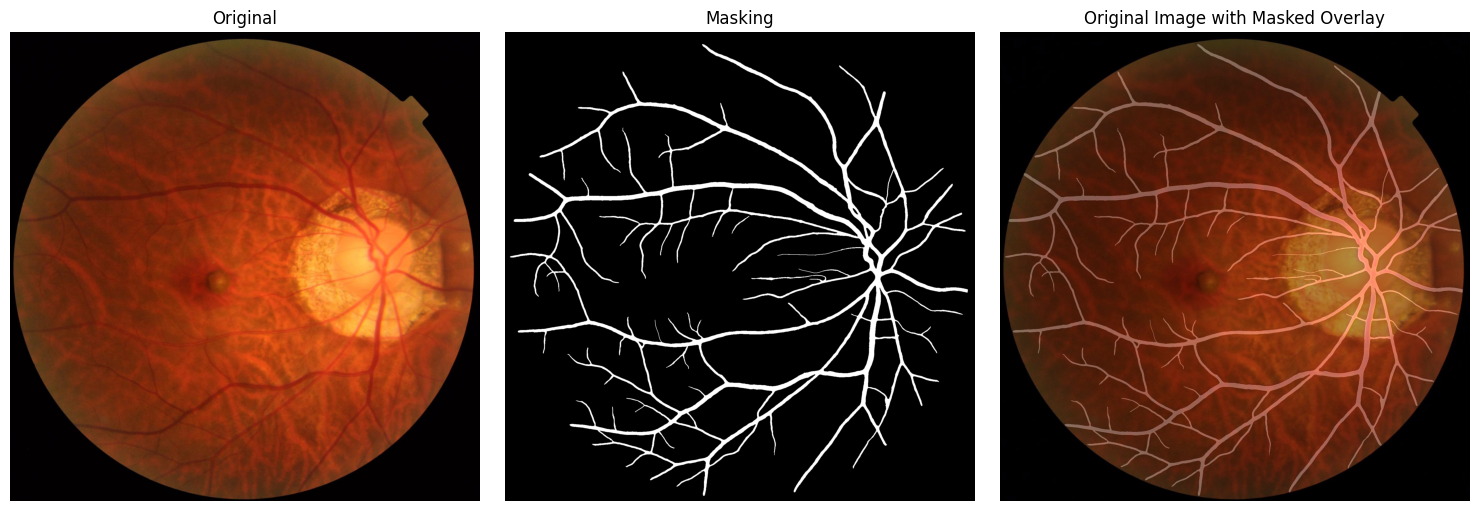

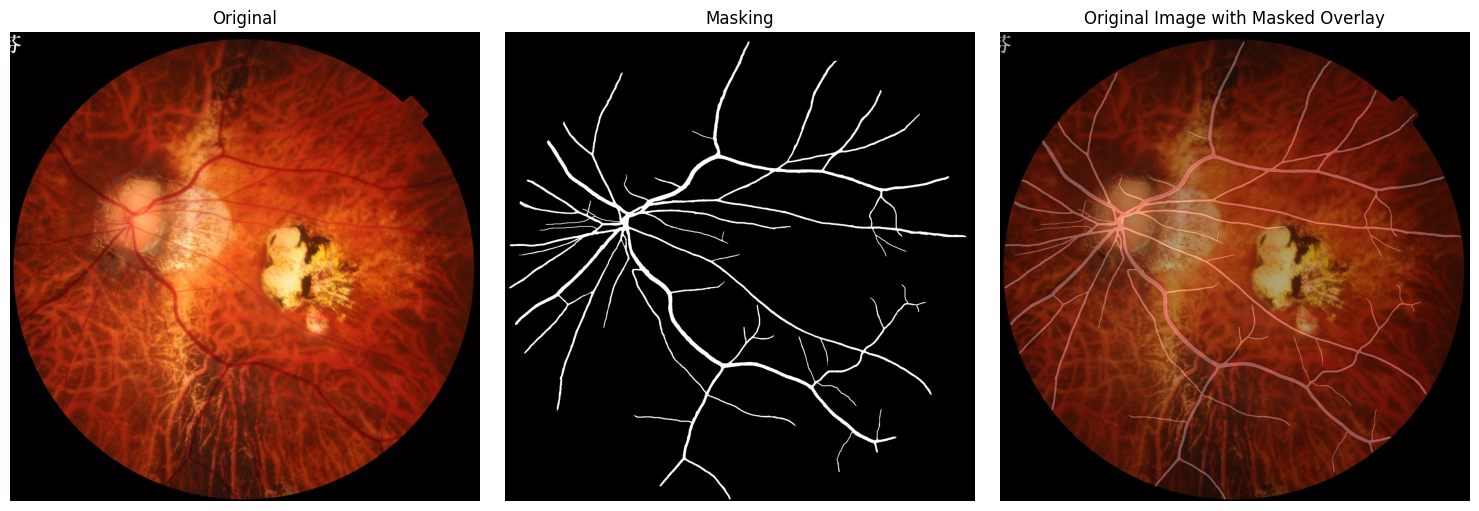

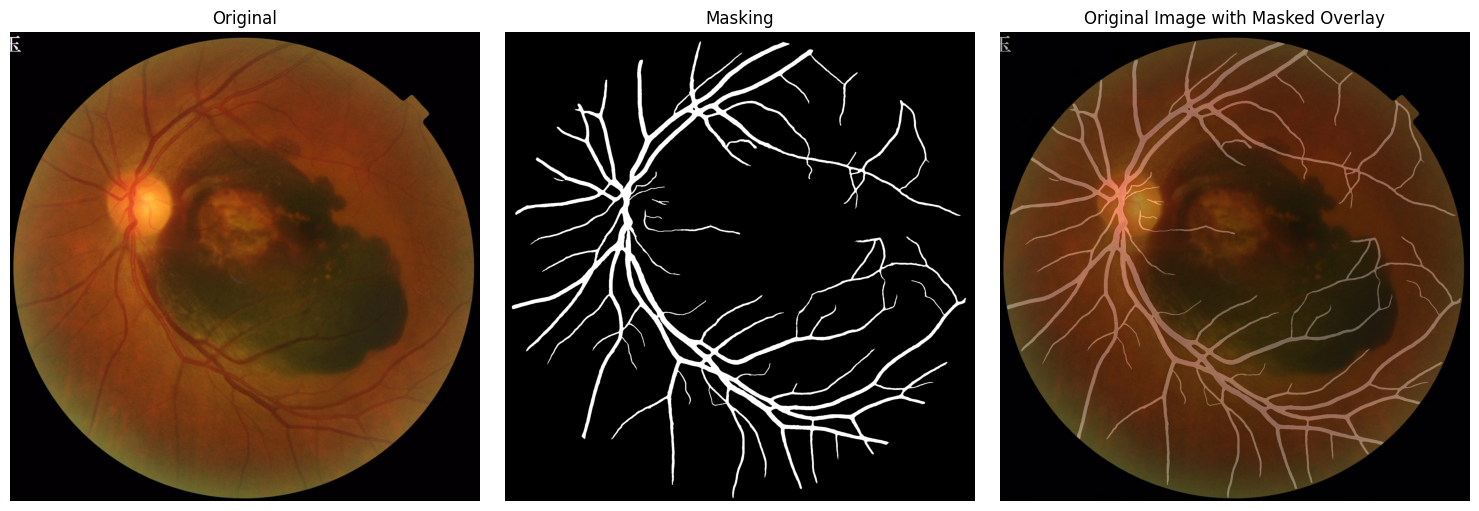

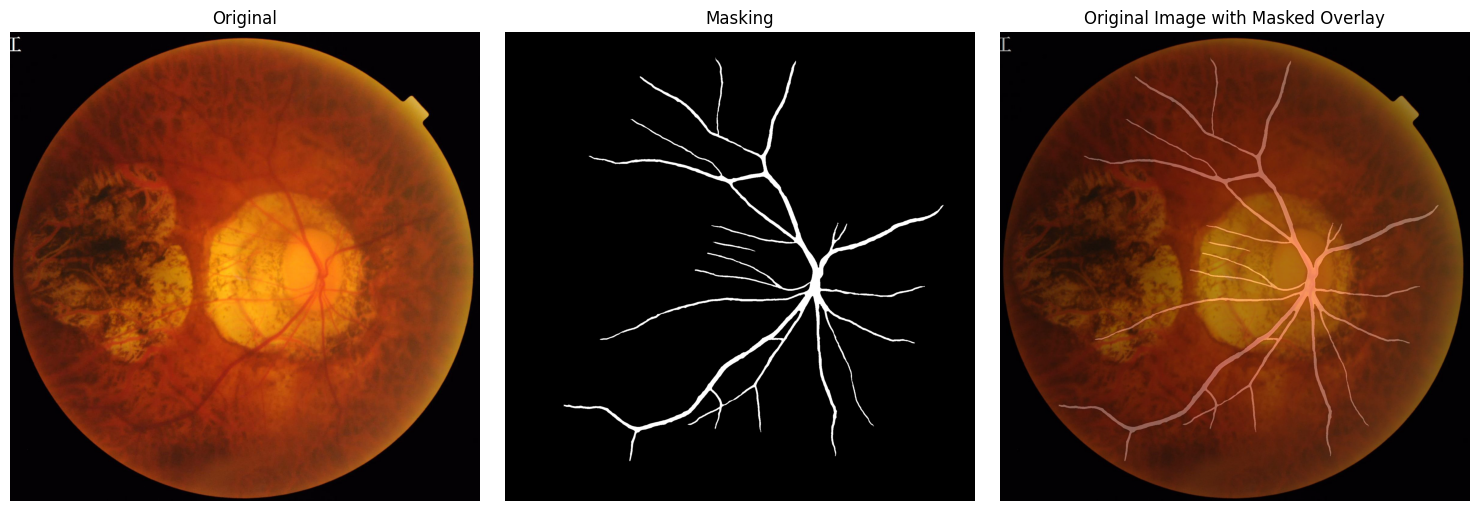

In [13]:
for i in range(len(processed_originals)):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(processed_originals[i])
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(processed_masks[i])
    plt.title("Masking")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(processed_overlays[i])
    plt.title("Original Image with Masked Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


This code block performs the initial setup for data preprocessing by ensuring that the necessary output directories exist for storing the processed images and masks. It uses `os.makedirs` with `exist_ok=True` to create the directories if they do not already exist, preventing errors during the saving phase.

Additionally, it lists all image filenames present in both the training and testing original image directories. These lists (`image_names` and `test_image_names`) will be used to iterate over the datasets during preprocessing.

This setup step is crucial to organize the data pipeline, allowing subsequent processing steps to efficiently read from source folders and save the preprocessed data to designated output locations.

In [ ]:
# Create output directories
os.makedirs(processed_original_base, exist_ok=True)
os.makedirs(processed_mask_base, exist_ok=True)

# List all image files
image_names = os.listdir(original_base)

# Create output directories if not exist
os.makedirs(processed_original_test_base, exist_ok=True)
os.makedirs(processed_mask_test_base, exist_ok=True)

# List all test image files
test_image_names = os.listdir(original_test_base)

### Explanation of the Data Augmentation and Preprocessing Pipeline

1.  **Purpose of Data Augmentation and Preprocessing:**
    To improve the robustness and generalization capability of machine learning models, especially in medical imaging tasks, input images and their corresponding masks are augmented and standardized through a series of transformations.

2.  **Transformations Applied to Original Images:**

    * **Resizing:**
        Each original image is resized to a fixed dimension $224 \times 224$ pixels to maintain uniform input size across the dataset, essential for batch processing in deep learning models.
        Mathematically:
        $I_{\text{resized}} = \text{Resize}(I, (224, 224))$

    * **Random Horizontal Flip:**
        This stochastic operation flips the image horizontally with a probability $p = 0.5$, simulating variability in image orientation.
        $I' = \begin{cases} \text{FlipHorizontal}(I), & \text{with probability } 0.5 \\ I, & \text{otherwise} \end{cases}$

    * **Random Rotation:**
        The image is rotated by a random angle $\theta \in [-15^\circ, 15^\circ]$, allowing the model to learn invariance to slight rotations.
        $I' = \text{Rotate}(I, \theta), \quad \theta \sim \mathcal{U}(-15^\circ, 15^\circ)$

    * **Color Jittering:**
        Small random perturbations are applied to brightness, contrast, saturation, and hue, each within $\pm 10\%$ of their original values, to mimic different lighting and imaging conditions.
        $I' = \text{ColorJitter}(I; \Delta_{\text{brightness}}=0.1, \Delta_{\text{contrast}}=0.1, \Delta_{\text{saturation}}=0.1, \Delta_{\text{hue}}=0.1)$

    * **Random Affine Translation:**
        The image is randomly translated by up to $10\%$ of its width and height, simulating shifts in image acquisition.
        $I' = \text{AffineTranslate}(I, t_x, t_y), \quad t_x, t_y \sim \mathcal{U}(-0.1, 0.1)$

    * **Random Resized Crop:**
        A random crop of the image is extracted at a scale ranging from $80\%$ to $100\%$ of the original size and then resized back to $224 \times 224$, increasing spatial variance.
        $I' = \text{RandomResizedCrop}(I, \text{scale}=(0.8, 1.0), \text{size}=(224, 224))$

3.  **Transformations Applied to Masks:**

    * Masks undergo only **geometric transformations** that correspond spatially to the transformations applied to the original images to maintain pixel-level alignment crucial for segmentation tasks.
    * These include resizing, horizontal flips, rotations, and affine translations, **but exclude color jittering or cropping**, since masks represent binary or categorical pixel labels.
    * This ensures that for each pixel coordinate $(x,y)$, the mask value $M(x,y)$ aligns with the corresponding pixel in the transformed original image.

4.  **Synchronization of Random Transformations:**

    * To guarantee that the spatial transformations applied to an image and its corresponding mask are **exactly the same**, a random seed is generated and set before each transformation step.
    * This ensures deterministic and consistent augmentation, preserving the integrity of the image-mask pairs for supervised learning.

5.  **Loading and Saving:**

    * Images and masks are loaded in RGB format to maintain color channels.
    * After applying the respective transformations, the processed images and masks are saved to their corresponding output directories.
    * The process iterates over all images in the dataset, skipping any missing files to ensure robustness.

6.  **Outcome:**

    * This pipeline yields a dataset of uniformly sized, augmented image-mask pairs ready for model training.
    * The augmentation improves model generalization by exposing it to a wider range of plausible variations in the data, critical for medical image analysis where sample size is often limited.

---

In [ ]:
# Define transforms for original images (augment + resize)
train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
])

# Define transforms for masks (only geometric transforms + resize)
mask_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
])

for img_name in image_names:
    orig_path = os.path.join(original_base, img_name)
    mask_path = os.path.join(mask_base, img_name)

    if not os.path.exists(orig_path) or not os.path.exists(mask_path):
        print(f"Skipping {img_name}, missing file.")
        continue

    original_img = Image.open(orig_path).convert("RGB")
    mask_img = Image.open(mask_path).convert("RGB")

    # Use same seed so transforms are consistent
    seed = random.randint(0, 99999)
    random.seed(seed)
    torch.manual_seed(seed)
    processed_orig = train_transform(original_img)

    random.seed(seed)
    torch.manual_seed(seed)
    processed_mask = mask_transform(mask_img)

    # Save processed images
    processed_orig.save(os.path.join(processed_original_base, img_name))
    processed_mask.save(os.path.join(processed_mask_base, img_name))

    print(f"Processed and saved {img_name}")

print("Data preprocessing complete.")


Processed and saved 100_A.png
Processed and saved 101_A.png
Processed and saved 102_A.png
Processed and saved 103_A.png
Processed and saved 104_A.png
Processed and saved 105_A.png
Processed and saved 106_A.png
Processed and saved 107_A.png
Processed and saved 108_A.png
Processed and saved 109_A.png
Processed and saved 10_A.png
Processed and saved 110_A.png
Processed and saved 111_A.png
Processed and saved 112_A.png
Processed and saved 113_A.png
Processed and saved 114_A.png
Processed and saved 115_A.png
Processed and saved 116_A.png
Processed and saved 117_A.png
Processed and saved 118_A.png
Processed and saved 119_A.png
Processed and saved 11_A.png
Processed and saved 120_A.png
Processed and saved 121_A.png
Processed and saved 122_A.png
Processed and saved 123_A.png
Processed and saved 124_A.png
Processed and saved 125_A.png
Processed and saved 126_A.png
Processed and saved 127_A.png
Processed and saved 128_A.png
Processed and saved 129_A.png
Processed and saved 12_A.png
Processed and

### Explanation of the Test Data Preprocessing Pipeline

1.  **Purpose of Test Data Preprocessing:**
    The primary goal of this pipeline is to prepare unseen (**test**) images and their corresponding ground truth masks for model evaluation. Unlike training data, test data undergoes a simplified preprocessing routine to ensure that the model is evaluated on data that closely resembles real-world, unaugmented inputs, while still meeting the input requirements of the model. This process focuses on **standardization** rather than **augmentation**, preventing data leakage from augmentation techniques during evaluation.

2.  **Transformations Applied to Test Original Images:**

    * **Resizing (Deterministic Downscaling/Upscaling):**
        Each original test image is deterministically resized to a fixed dimension of $224 \times 224$ pixels. This operation is crucial for ensuring that all input images conform to the expected input shape of a pre-trained deep learning model, which often requires fixed-size inputs. No random operations are applied here, as the objective is consistent evaluation.

        Mathematically:
        $$I_{\text{resized}} = \text{Resize}(I, (224, 224))$$
        where $I$ is the original test image, and $(224, 224)$ is the target resolution.

3.  **Transformations Applied to Test Masks:**

    * **Resizing (Deterministic Downscaling/Upscaling):**
        Similarly, each test mask undergoes the exact same deterministic resizing operation to $224 \times 224$ pixels. This is paramount for maintaining **spatial alignment** between the processed original image and its corresponding ground truth mask. For segmentation tasks, accurate pixel-level correspondence between input and target is vital for calculating loss and performance metrics.

        Mathematically:
        $$M_{\text{resized}} = \text{Resize}(M, (224, 224))$$
        where $M$ is the original test mask, and $(224, 224)$ is the target resolution.

4.  **Sequential Processing and File Handling:**

    * **Iterative File Access:** The pipeline iterates through a predefined list of `test_image_names`, ensuring that each image-mask pair in the test set is processed.
    * **Path Construction:** For each `img_name`, the full file paths for both the original image and its mask are constructed by joining the base directories (`original_test_base`, `mask_test_base`) with the image file name. This modular approach enhances readability and maintainability.
    * **Robustness Check (File Existence Verification):** Before attempting to open and process any image or mask, a critical check is performed to verify if both the original image and its corresponding mask actually exist at their expected paths. If either file is missing, a message is printed, and that specific image pair is gracefully skipped. This prevents runtime errors due to corrupted or incomplete datasets.
    * **Image Loading and Format Conversion:**
        * Original images are loaded using `Image.open()` and immediately converted to **"RGB"** format. This ensures all images have three color channels, standardizing input for models trained on color images, even if some original test images might be grayscale.
        * Masks are also loaded and converted to "RGB". While masks often represent single-channel binary or categorical data, converting them to "RGB" here ensures consistent data type handling with the image transformations.
    * **Application of Transforms:** The defined `test_transform` is applied to the `original_img`, and `test_mask_transform` is applied to `mask_img`. These operations, as detailed above, consist solely of deterministic resizing.
    * **Saving Processed Data:** The transformed `processed_orig` and `processed_mask` are then saved to their respective output directories (`processed_original_test_base`, `processed_mask_test_base`) using their original file names. This maintains a clear correspondence between the original and processed test data.
    * **Progress Notification:** A print statement confirms the successful processing and saving of each image pair, providing real-time feedback on the pipeline's progress.

5.  **Outcome:**

    * This pipeline generates a clean, standardized set of test image-mask pairs, all uniformly resized to $224 \times 224$ pixels.
    * Crucially, by avoiding any stochastic augmentation, this preprocessing ensures that the model's performance on the test set is an **unbiased reflection** of its generalization capability to unmanipulated, real-world data. This is essential for accurate model evaluation and comparison.
    * The robust file handling mechanism prevents pipeline failure due to missing data, contributing to the overall stability of the data preparation phase.

In [ ]:
# Define transforms for test original images (only resize, no augmentation)
test_transform = T.Compose([
    T.Resize((224, 224)),
])

# Define transforms for test masks (only resize)
test_mask_transform = T.Compose([
    T.Resize((224, 224))
])

for img_name in test_image_names:
    orig_path = os.path.join(original_test_base, img_name)
    mask_path = os.path.join(mask_test_base, img_name)

    if not os.path.exists(orig_path) or not os.path.exists(mask_path):
        print(f"Skipping {img_name}, missing file.")
        continue

    original_img = Image.open(orig_path).convert("RGB")
    mask_img = Image.open(mask_path).convert("RGB")

    processed_orig = test_transform(original_img)
    processed_mask = test_mask_transform(mask_img)

    processed_orig.save(os.path.join(processed_original_test_base, img_name))
    processed_mask.save(os.path.join(processed_mask_test_base, img_name))

    print(f"Processed and saved {img_name}")

print("Test data preprocessing complete.")


Processed and saved 100_D.png
Processed and saved 101_G.png
Processed and saved 102_G.png
Processed and saved 103_G.png
Processed and saved 104_G.png
Processed and saved 105_G.png
Processed and saved 106_G.png
Processed and saved 107_G.png
Processed and saved 108_G.png
Processed and saved 109_G.png
Processed and saved 10_A.png
Processed and saved 110_G.png
Processed and saved 111_G.png
Processed and saved 112_G.png
Processed and saved 113_G.png
Processed and saved 114_G.png
Processed and saved 115_G.png
Processed and saved 116_G.png
Processed and saved 117_G.png
Processed and saved 118_G.png
Processed and saved 119_G.png
Processed and saved 11_A.png
Processed and saved 120_G.png
Processed and saved 121_G.png
Processed and saved 122_G.png
Processed and saved 123_G.png
Processed and saved 124_G.png
Processed and saved 125_G.png
Processed and saved 126_G.png
Processed and saved 127_G.png
Processed and saved 128_G.png
Processed and saved 129_G.png
Processed and saved 12_A.png
Processed and